In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [4]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'D:/Ocular/preprocessed_split/train'
valid_path = 'D:/Ocular/preprocessed_split/test'
#train_path = 'D:/Ocular/increased_data/train'
#valid_path = 'D:/Ocular/increased_data/test'

In [5]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

#inception = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

inception = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [6]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [7]:
# useful for getting number of output classes
folders = glob('D:/Ocular/preprocessed_split/train/*')
#folders = glob('D:/Ocular/increased_data/train/*')

In [8]:
print(folders)

['D:/Ocular/preprocessed_split/train\\agedegen', 'D:/Ocular/preprocessed_split/train\\cataract', 'D:/Ocular/preprocessed_split/train\\diabetes', 'D:/Ocular/preprocessed_split/train\\normal']


In [9]:
# our layers - you can add more if you want
x = Flatten()(inception.output)
x = Dropout(0.3)(x)


In [10]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [11]:
# view the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:

# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('D:/Ocular/preprocessed_split/train',
                                                 target_size = (224, 224),
                                                 batch_size = 20,
                                                 class_mode = 'categorical')

Found 972 images belonging to 4 classes.


In [15]:
test_set = test_datagen.flow_from_directory('D:/Ocular/preprocessed_split/test',
                                            target_size = (224, 224),
                                            batch_size = 20,
                                            class_mode = 'categorical')

Found 192 images belonging to 4 classes.


In [16]:
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set), shuffle = True)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
49/49 [==============================] - 249s 5s/step - loss: 0.6100 - accuracy: 0.4527 - val_loss: 0.5146 - val_accuracy: 0.4740
Epoch 2/50
49/49 [==============================] - 228s 5s/step - loss: 0.4225 - accuracy: 0.5710 - val_loss: 0.4571 - val_accuracy: 0.5000
Epoch 3/50
49/49 [==============================] - 227s 5s/step - loss: 0.3674 - accuracy: 0.6276 - val_loss: 0.5346 - val_accuracy: 0.5417
Epoch 4/50
49/49 [==============================] - 228s 5s/step - loss: 0.3534 - accuracy: 0.6687 - val_loss: 0.4157 - val_accuracy: 0.5677
Epoch 5/50
49/49 [==============================] - 228s 5s/step - loss: 0.3535 - accuracy: 0.6543 - val_loss: 0.4974 - val_accuracy: 0.5312
Epoch 6/50
49/49 [==============================] - 228s 5s/step - loss: 0.3329 - accuracy: 0.6883 - val_loss: 0.4165 - val_accuracy: 0.5677
Epoch 7/50
49/49 [==============================] - 229s 5s/step - loss: 0.338

In [21]:
import matplotlib.pyplot as plt

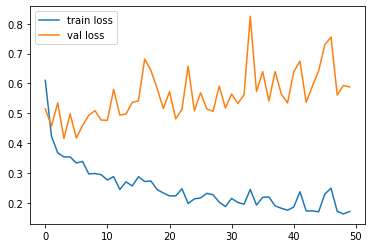

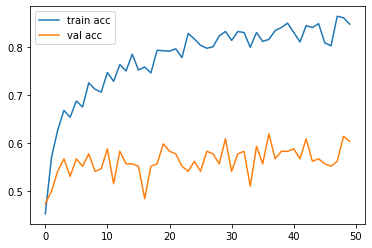

<Figure size 432x288 with 0 Axes>

In [22]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [23]:
from tensorflow.keras.models import load_model

model.save('model_inception.h5')

In [24]:
y_pred_proba = r.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

AttributeError: 'History' object has no attribute 'predict_proba'

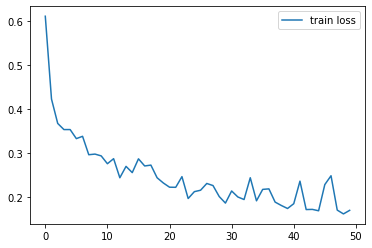

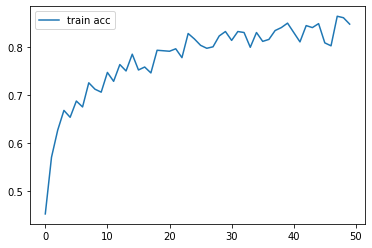

<Figure size 432x288 with 0 Axes>

In [25]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.legend()
plt.show()
plt.savefig('train_only_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.legend()
plt.show()
plt.savefig('train_only_acc')

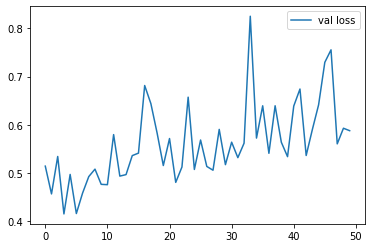

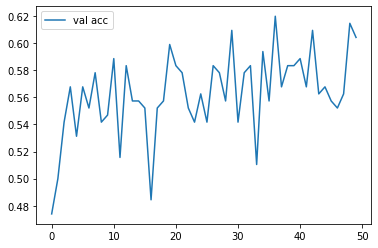

<Figure size 432x288 with 0 Axes>

In [26]:
# plot the loss
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('Val_only_loss')

# plot the accuracy
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('Val_only_acc')